In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'/content/drive/MyDrive/dataset-resized'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/dataset-resized/paper/paper103.jpg
/content/drive/MyDrive/dataset-resized/paper/paper114.jpg
/content/drive/MyDrive/dataset-resized/paper/paper106.jpg
/content/drive/MyDrive/dataset-resized/paper/paper108.jpg
/content/drive/MyDrive/dataset-resized/paper/paper112.jpg
/content/drive/MyDrive/dataset-resized/paper/paper113.jpg
/content/drive/MyDrive/dataset-resized/paper/paper111.jpg
/content/drive/MyDrive/dataset-resized/paper/paper116.jpg
/content/drive/MyDrive/dataset-resized/paper/paper107.jpg
/content/drive/MyDrive/dataset-resized/paper/paper10.jpg
/content/drive/MyDrive/dataset-resized/paper/paper101.jpg
/content/drive/MyDrive/dataset-resized/paper/paper102.jpg
/content/drive/MyDrive/dataset-resized/paper/paper110.jpg
/content/drive/MyDrive/dataset-resized/paper/paper11.jpg
/content/drive/MyDrive/dataset-resized/paper/paper100.jpg
/content/drive/MyDrive/dataset-resized/paper/paper104.jpg
/content/drive/MyDrive/dataset-resized/paper/paper1.jpg
/content/drive/MyD

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Create Files_Name
image_data="/content/drive/MyDrive/dataset-resized"
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

Files_Name
0      paper
1      glass
2      metal
3  cardboard
4    plastic
5      trash

In [ ]:
import tensorflow as tf

# Define parameters
train_data_dir = image_data
batch_size = 32
target_size = (224, 224)
validation_split = 0.1
test_split = 0.2

# Load the entire dataset
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

# Split the dataset into training and validation subsets
num_examples = full_dataset.cardinality().numpy()
train_size = int((1 - validation_split - test_split) * num_examples)
val_size = int(validation_split * num_examples)

train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size).take(val_size)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 2527 files belonging to 6 classes.
Using 2275 files for training.
Found 2527 files belonging to 6 classes.
Using 252 files for validation.


In [ ]:
class_names = full_dataset.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

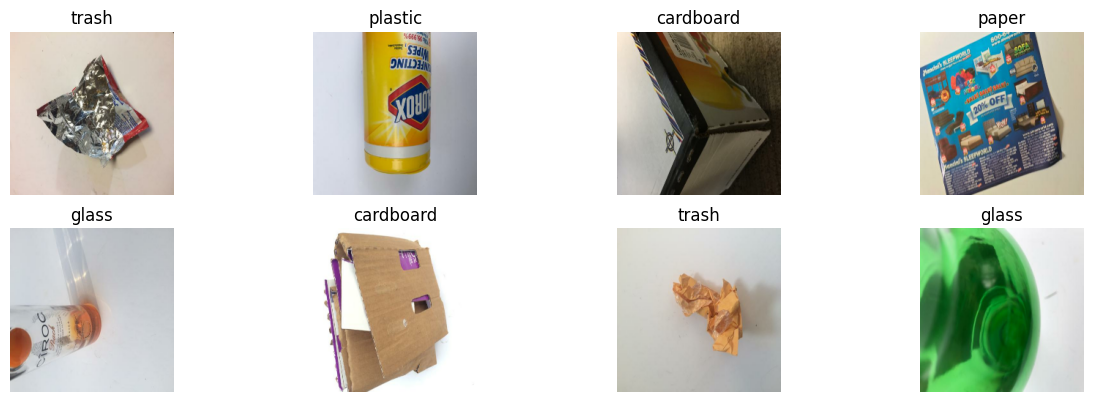

In [ ]:
plt.figure(figsize=(15, 20))
for images, labels in train_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define MobileNetV3 with pre-trained weights
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers in the base model
base_model.trainable = False

# Build the sequential model
mobilenetv3_model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')
])

# Compile the model
mobilenetv3_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Provide a sample input
sample_input = tf.random.normal((1, 224, 224, 3))

# Call the model with the sample input to initialize the shapes
_ = mobilenetv3_model(sample_input)

# Print model summary
mobilenetv3_model.summary()

# Define callbacks
checkpoint = ModelCheckpoint(filepath='mobilenetv3_model.keras', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
hist = mobilenetv3_model.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d_4  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 576)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 3462      
                                                                 
Total params: 942582 (3.60 MB)
Trainable params: 3462 (13.52 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________
Epoch 1/20
50/50

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define MobileNetV3 with pre-trained weights
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Unfreeze some layers for fine-tuning
fine_tune_at = 100  # Example: Fine-tune from layer 100 onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build the sequential model
mobilenetv3_model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')  # Assuming num_classes is defined
])

# Compile the model
mobilenetv3_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
mobilenetv3_model.summary()

# Define callbacks
checkpoint = ModelCheckpoint(filepath='mobilenetv3_model_finetuned.keras', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
hist1 = mobilenetv3_model.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d_6  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 576)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 3462      
                                                                 
Total params: 942582 (3.60 MB)
Trainable params: 816998 (3.12 MB)
Non-trainable params: 125584 (490.56 KB)
_________________________________________________________________
Epoch 1/10
50

In [ ]:
# Save the fine-tuned MobileNetV3 model to your Google Drive
mobilenetv3_model.save('/content/drive/MyDrive/models/mobilenetv3_model_finetuned.h5')


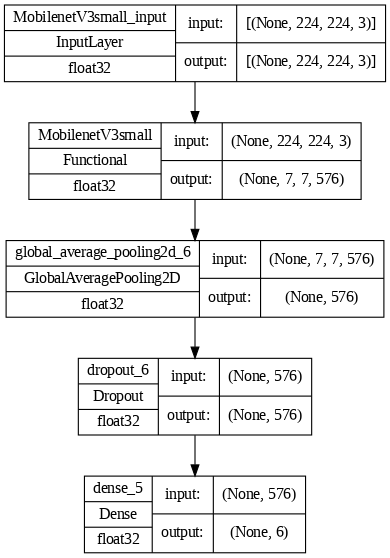

In [ ]:
tf.keras.utils.plot_model(mobilenetv3_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)


In [ ]:
hist11=pd.DataFrame(hist1.history)
hist11

loss  accuracy  val_loss  val_accuracy
0  1.047474  0.608125  0.951056      0.696429
1  0.409863  0.858125  0.576512      0.794643
2  0.202644  0.934375  0.644093      0.830357
3  0.155336  0.946875  0.664872      0.808036
4  0.120126  0.961250  0.983901      0.767857
5  0.104073  0.966250  0.442743      0.897321
6  0.052765  0.986875  0.681713      0.866071
7  0.050652  0.983750  0.568851      0.879464
8  0.061463  0.980625  1.155928      0.821429
9  0.042300  0.986250  0.668765      0.897321

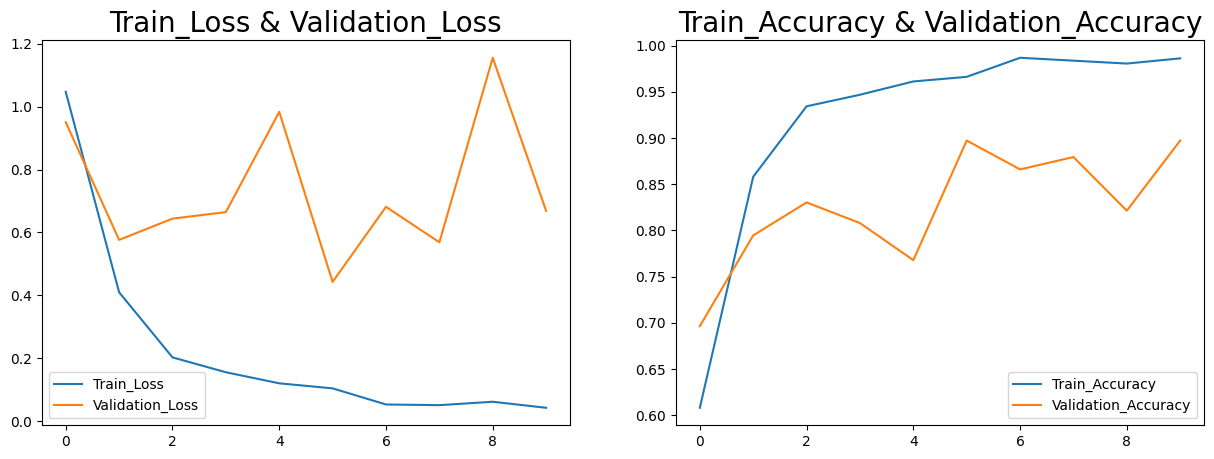

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist11['loss'],label='Train_Loss')
plt.plot(hist11['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist11['accuracy'],label='Train_Accuracy')
plt.plot(hist11['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation_dataset:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=mobilenetv3_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

7/7 [==============================] - 1s 24ms/step


Actual  Prediction
0         0           0
1         1           1
2         2           2
3         5           4
4         2           2
..      ...         ...
219       5           4
220       2           2
221       3           3
222       2           2
223       2           2

[224 rows x 2 columns]

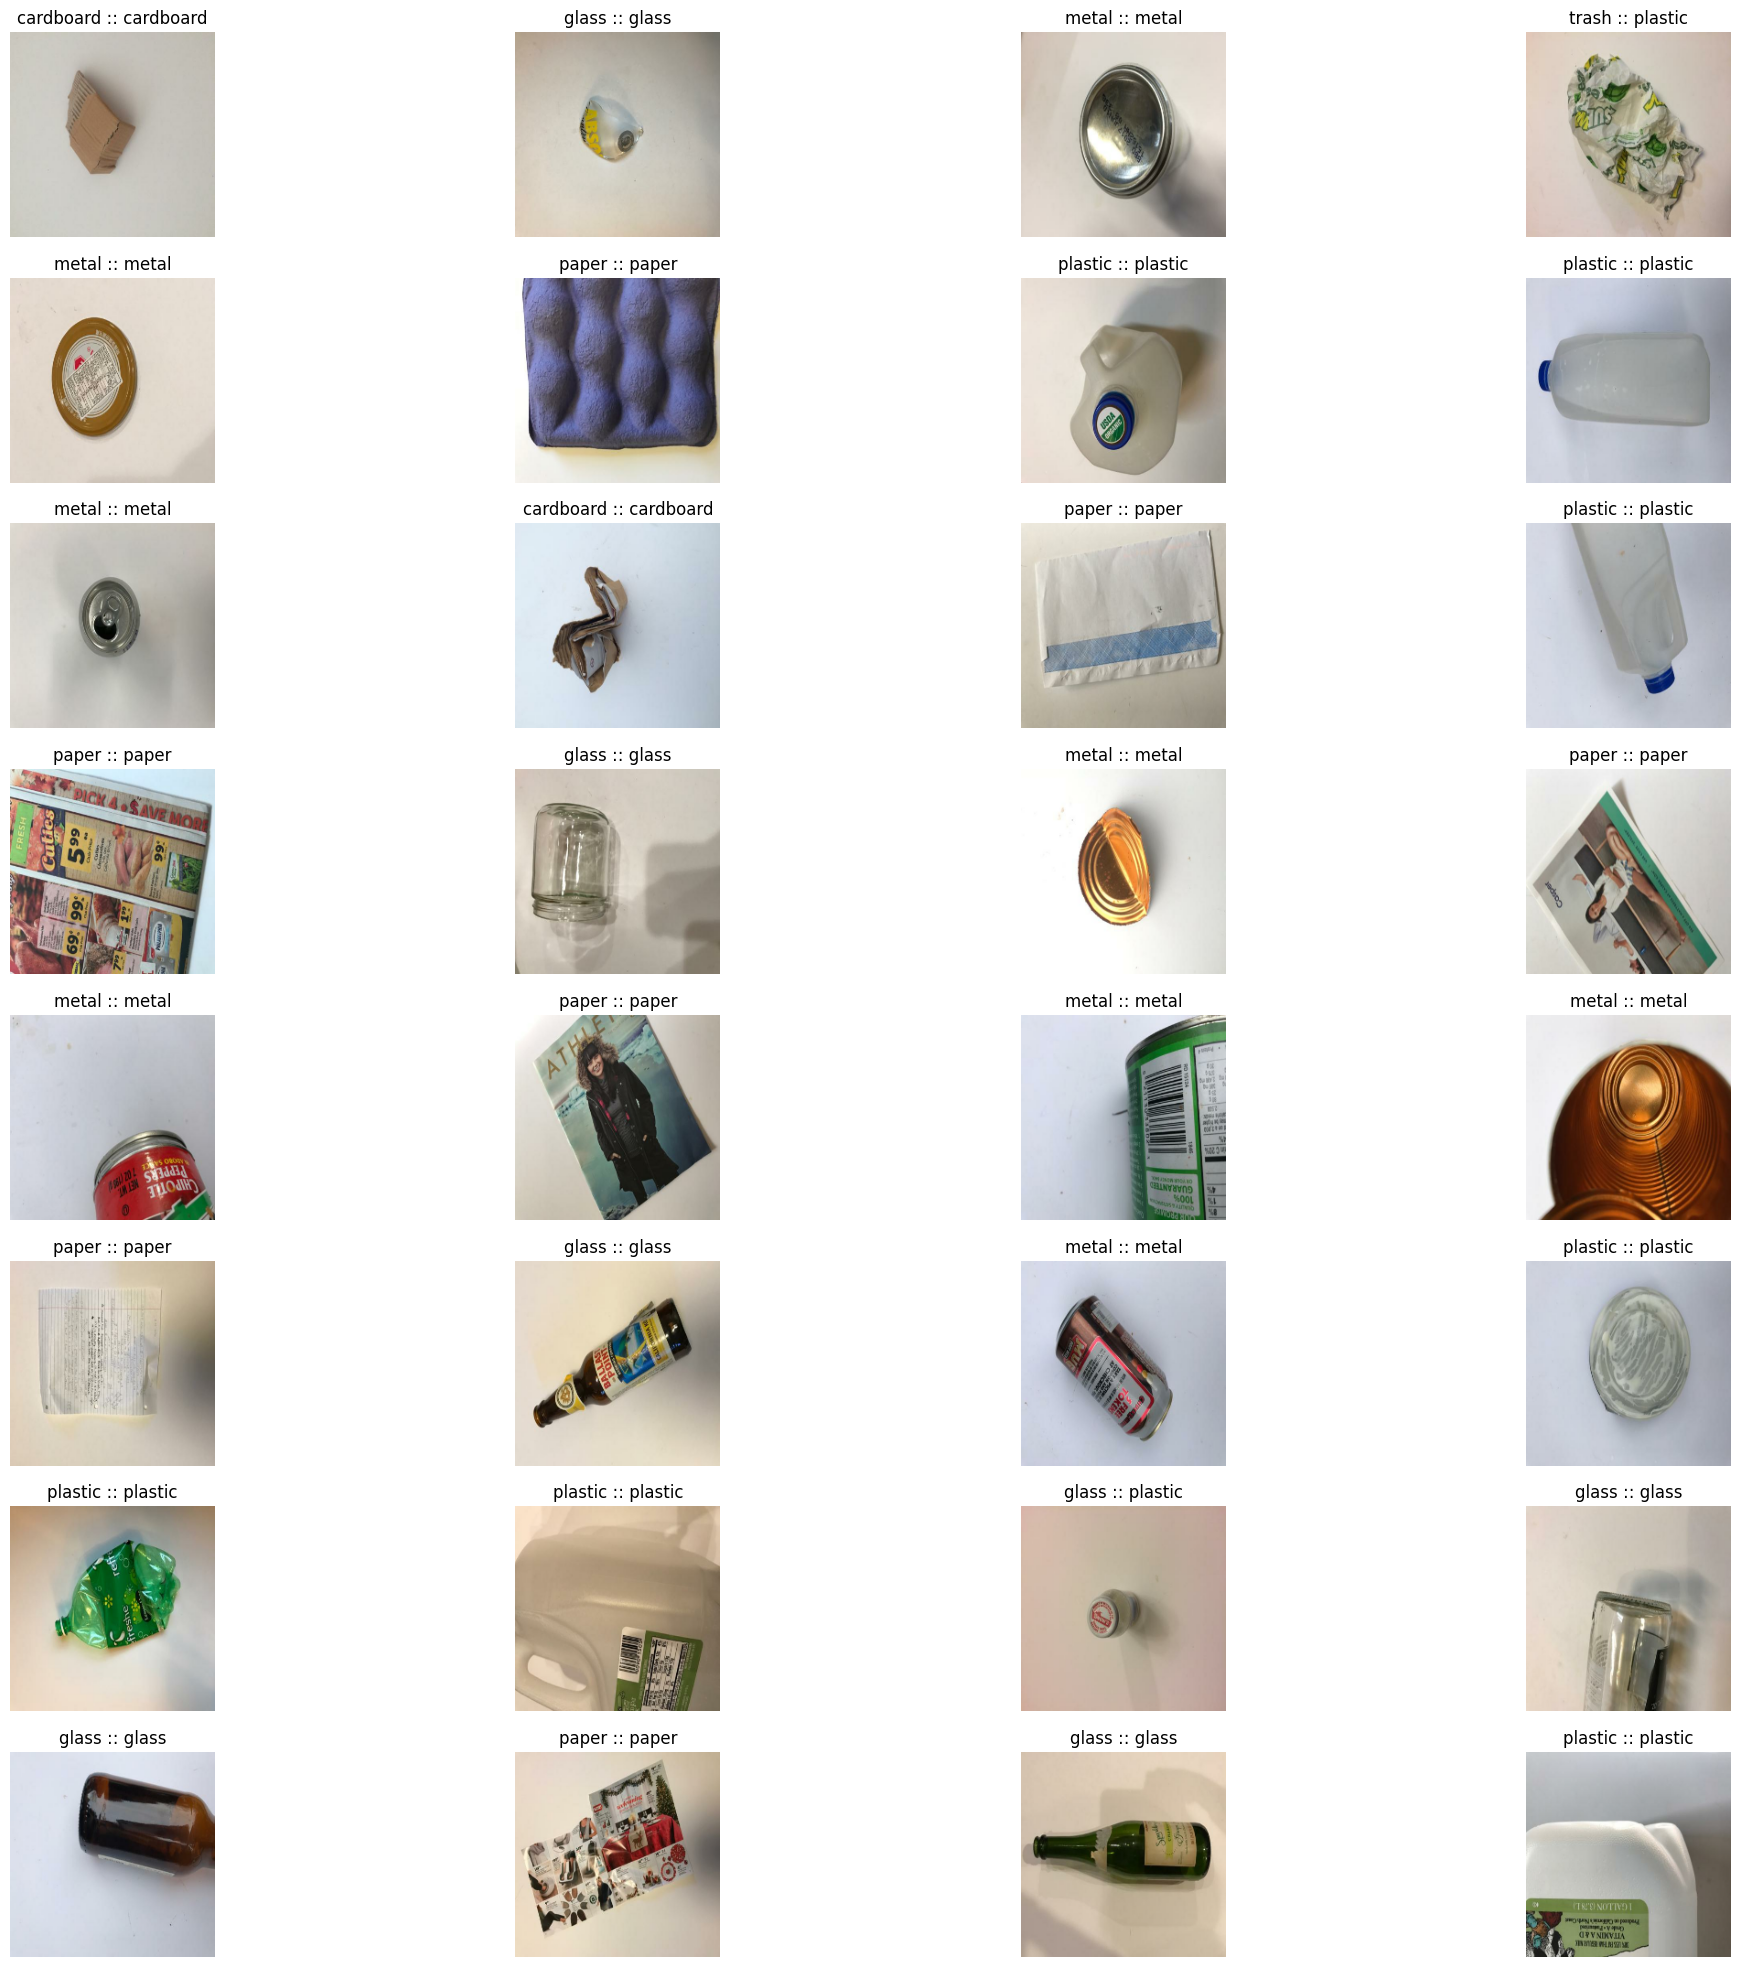

In [ ]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

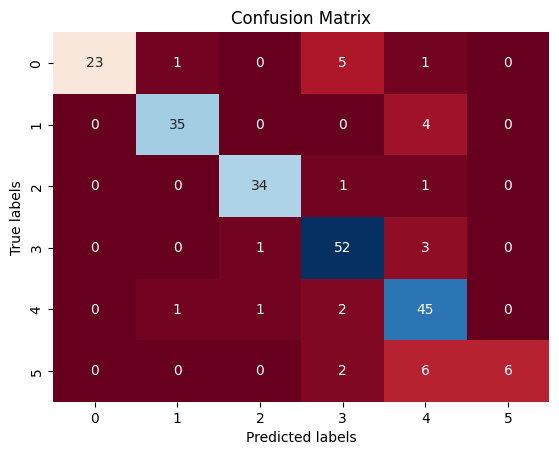

array([[23,  1,  0,  5,  1,  0],
       [ 0, 35,  0,  0,  4,  0],
       [ 0,  0, 34,  1,  1,  0],
       [ 0,  0,  1, 52,  3,  0],
       [ 0,  1,  1,  2, 45,  0],
       [ 0,  0,  0,  2,  6,  6]])

In [ ]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

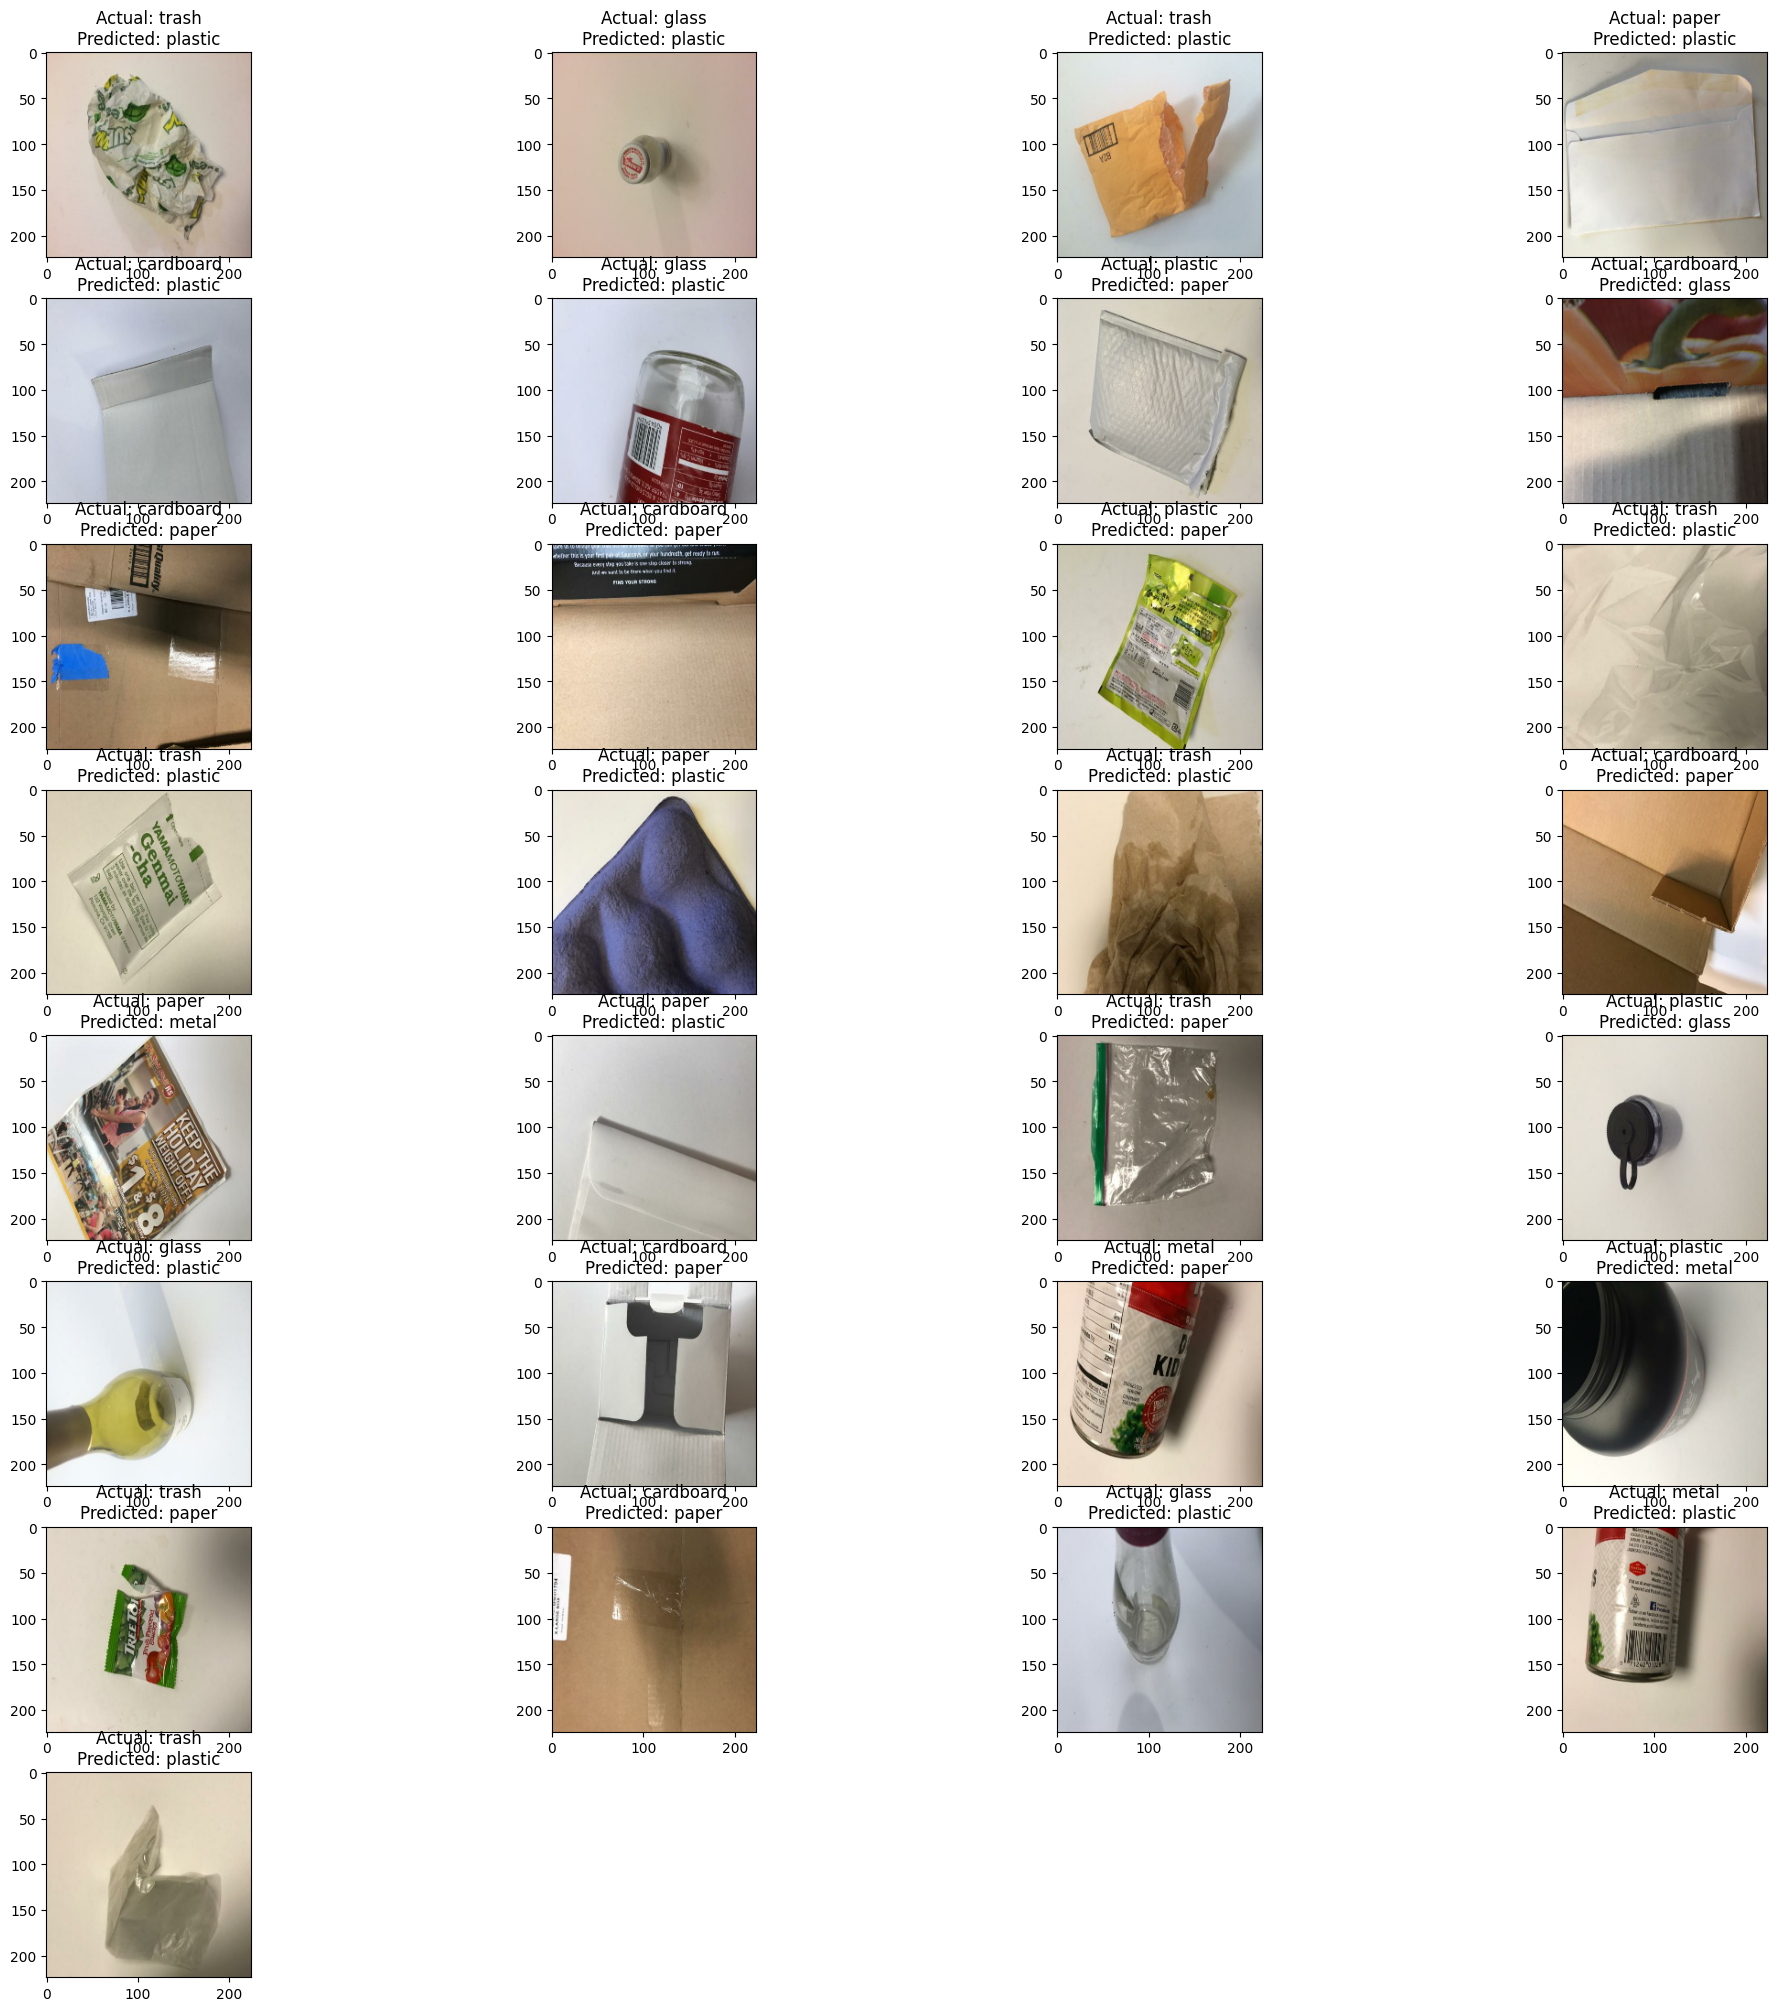

In [ ]:
plt.figure(figsize=(25, 25))
plot_count = 1  # Counter to keep track of the number of plotted images
for i in range(len(X_val)):
    if class_names[y_val[i]] != class_names[y_pred[i]]:
        ax = plt.subplot(8, 4, plot_count)
        plt.imshow(X_val[i].astype("uint8"))
        ax.title.set_text(f"Actual: {class_names[y_val[i]]}\nPredicted: {class_names[y_pred[i]]}")
        plot_count += 1
        if plot_count > 32:  # Plot up to 32 mismatched images
            break
plt.show()

In [ ]:
# prompt: give me the accuracy of each class

from sklearn.metrics import classification_report

# Get the classification report
report = classification_report(y_val, y_pred)

# Print the accuracy for each class
print(report)


              precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.95      0.90      0.92        39
           2       0.94      0.94      0.94        36
           3       0.84      0.93      0.88        56
           4       0.75      0.92      0.83        49
           5       1.00      0.43      0.60        14

    accuracy                           0.87       224
   macro avg       0.91      0.81      0.84       224
weighted avg       0.89      0.87      0.87       224



In [ ]:
# prompt: print the index and class label of each

# Create a dictionary to store the class names and their corresponding indices
class_names = full_dataset.class_names
class_names_to_indices = {class_name: i for i, class_name in enumerate(class_names)}

# Print the index and class label for each class
for class_name, index in class_names_to_indices.items():
  print(f"Index: {index}, Class Label: {class_name}")


Index: 0, Class Label: cardboard
Index: 1, Class Label: glass
Index: 2, Class Label: metal
Index: 3, Class Label: paper
Index: 4, Class Label: plastic
Index: 5, Class Label: trash


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Convert y_val and y_pred to NumPy arrays if they are not already
y_val = np.array(y_val)
y_pred = np.array(y_pred)

# Calculate the accuracy for each class
class_accuracies = {}
unique_labels = np.unique(y_val)
for label in unique_labels:
    indices = np.where(y_val == label)[0]  # Get indices where y_val equals the current label
    class_accuracies[label] = accuracy_score(y_val[indices], y_pred[indices])

# Print the accuracy for each class
for label, accuracy in class_accuracies.items():
    print(f"Accuracy for class {label}: {accuracy:.3f}")


Accuracy for class 0: 0.767
Accuracy for class 1: 0.897
Accuracy for class 2: 0.944
Accuracy for class 3: 0.929
Accuracy for class 4: 0.918
Accuracy for class 5: 0.429


In [ ]:
# prompt: give me the precision of the completer model

from sklearn.metrics import  precision_score

# Calculate precision for each class
precision = precision_score(y_val, y_pred, average='weighted')

# Print the precision
print(f"Precision: {precision:.3f}")


Precision: 0.887


In [ ]:
# prompt: give me the precision of the completer model

from sklearn.metrics import  recall_score

# Calculate precision for each class
recall = recall_score(y_val, y_pred, average='weighted')

# Print the precision
print(f"recall: {recall:.3f}")


recall: 0.871


In [ ]:
from sklearn.metrics import f1_score

# Calculate F1-score for each class
f1 = f1_score(y_val, y_pred, average='weighted')

# Print the F1-score
print(f"F1-score: {f1:.3f}")


F1-score: 0.867


In [ ]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.3f}%".format(Acc * 100))

accuracy is: 87.054%
